In [1]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4


In [2]:
load_dotenv()
llm = ChatGroq(model="openai/gpt-oss-120b")

In [5]:
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

memory = MemorySaver()

llm_with_tools = llm.bind_tools(tools = tools)


In [10]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return{
        "messages":[result],
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tools_calls") and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END

async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""

    tool_calls = state["messages"][-1].tool_calls

    tool_messages = []
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name=="tavily_search_results_json":
            search_results = await search_tool.ainvoke(tool_args)

            tool_message = ToolMessage(
                content = str(search_results),
                tool_call_id = tool_id,
                name = tool_name
            )
            tool_messages.append(tool_message)

    return {"messages": tool_messages}


graph_builder = StateGraph(State)
graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)





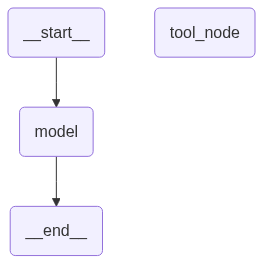

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [12]:
config = {
    "configurable":{
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages":[HumanMessage(content="Hi how are you doing?")],
    
}, config=config)

response

{'messages': [HumanMessage(content='Hi how are you doing?', additional_kwargs={}, response_metadata={}, id='970e220e-c589-4a1a-841c-117084920976'),
  HumanMessage(content='Hi how are you doing?', additional_kwargs={}, response_metadata={}, id='f8495b2a-58b7-4aa8-8e01-7e73883c234e'),
  AIMessage(content='Hello! I’m doing great, thanks for asking. How can I assist you today?', additional_kwargs={'reasoning_content': 'The user just says "Hi how are you doing?" It\'s a greeting. Should respond politely. No need for tool.'}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 170, 'total_tokens': 222, 'completion_time': 0.108635128, 'prompt_time': 0.007298314, 'queue_time': 0.045720696, 'total_time': 0.115933442}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ed9190d8b7', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--80590c95-9434-4d38-8505-7cb97aec7151-0', usage_metadata={'input_tokens': 170, 'output_tokens': 52,